In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
# from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

### Uploading shapefiles

The next shapefile contains the name of the quarter, the year of construction and the polygons of Benito Juarez, info available [here](https://sig.cdmx.gob.mx/datos/).

In [6]:
bj_gpd=gpd.read_file('data/shapes/BENITO_JUAREZ/BENITO_JUAREZ.shp')

In [4]:
bj_pd=pd.read_csv('data/shapes/BENITO_JUAREZ/BENITO_JUAREZ.csv')

We only keep Benito Juarez

In [9]:
bj_gpd_inegi=gpd.read_file('data/shapes/09m.shp')
bj_gpd_inegi=bj_gpd_inegi[bj_gpd_inegi['CVE_MUN']=='014']

We generate the **id** variable to merge the data.

In [10]:
bj_gpd_inegi['id']=bj_gpd_inegi['CVE_MUN']+bj_gpd_inegi['CVE_LOC']+bj_gpd_inegi['CVE_AGEB']+bj_gpd_inegi['CVE_MZA']

In [11]:
bj_pd=bj_pd[['fid','colonia_predio','anio_construccion']]

In [12]:
bj_gpd=bj_gpd.merge(bj_pd,on='fid',how='left')

### Importing the model results

In [49]:
results=pd.read_csv('data/results.csv')

Changing crs of INEGI's shapefiles

In [53]:
bj_gpd_inegi.to_crs(crs=crs,inplace=True)

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Merging INEGI shapefiles and results

In [55]:
bj_gpd_inegi=bj_gpd_inegi.merge(results,on='id',how='left')

Changing CRS of SIGCDMX

In [33]:
bj_gdp.to_crs(crs=crs,inplace=True)

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [64]:
bj_results=sjoin(bj_gpd_inegi,bj_gpd,how='left')

<ipython-input-64-24e0930859ad>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  bj_results=sjoin(bj_gpd_inegi,bj_gpd,how='left')


To plot the growth variable we have to set in zero the places were we didn't have information

In [74]:
bj_results['growth'][bj_results['growth'].isna()]=0

<ipython-input-74-056133da26c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bj_results['growth'][bj_results['growth'].isna()]=0


# Percentage $Price/m^2$ increase in 2010-2020 in Benito Juarez

<AxesSubplot:title={'center':'Price increase in Benito Juarez'}>

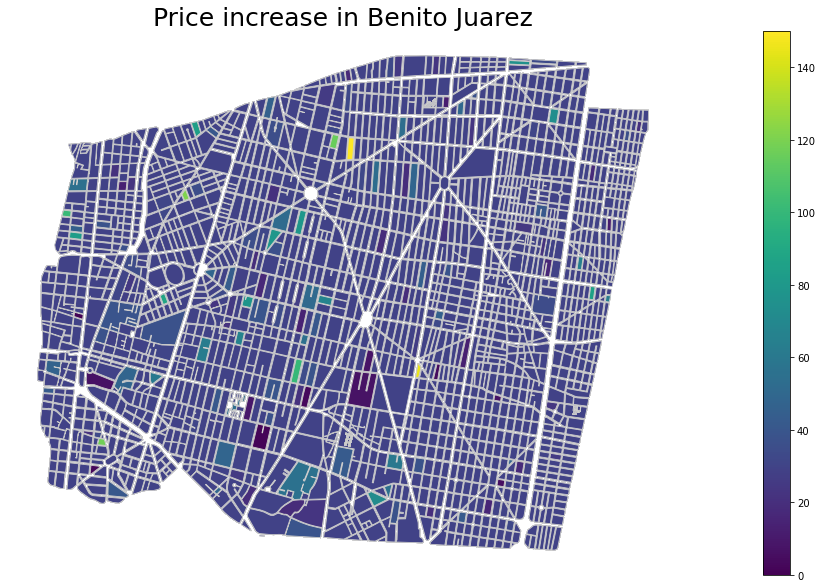

In [78]:
# set the value column that will be visualised
variable = 'growth'
# set the range for the choropleth values
vmin, vmax = 0, 150
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Price increase in Benito Juarez', fontdict={'fontsize': '25', 'fontweight' : '3'})
# ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
bj_results.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')